# Research Question 2: What topics do students cover in chatbot interactions?

RQ2 explores the content of student-chatbot interactions.
We preprocessed all messages (removing formatting, cor-
recting spelling, anonymizing numbers) and translated them
into English. We then used BERT for Topic modeling;
Sentence embeddings are created using a pre-trained trans-
former, followed by UMAP for dimensionality reduction and
HDBSCAN for clustering. Topics are then extracted using
class-based TF-IDF scores, and representative labels were
manually assigned to clusters based on top keywords and
example messages.

### Imports

In [2]:
import pandas as pd
import numpy as np
import re
import ast
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords

DATA_DIR = './data'

/opt/anaconda3/envs/text-analytics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the chatbot data
chat_bot = pd.read_csv('{}/original/gymitrainer.csv'.format(DATA_DIR))

In [4]:
chat_bot.head(5)

,Unnamed: 0,id,chat_profile,tag,message_count,startTime,endTime,content
0,0,8d8b7ed3-393a-4fff-a3de-3cd515399efa,NaN,NaN,0,1741330528,1741330535,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
1,1,f27276e8-eca8-419e-8f13-1677aac6c5b8,NaN,NaN,0,1741330363,1741330368,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
2,2,b870f1ce-6fd3-4353-96c3-7fb44c9add19,NaN,NaN,0,1741330310,1741330326,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
3,3,873d766b-baf9-4c88-a27b-9f842df763d8,NaN,NaN,0,1741330270,1741330294,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."
4,4,2c470a15-7dc4-4b83-be81-61501b325d0d,NaN,NaN,0,1741123788,1741123799,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."


## Preprocessing

Although BERT-based topic models often require only minimal text preprocessing, our experiments showed that careful cleaning substantially improves the coherence and interpretability of the resulting clusters. In particular, we convert each raw chat‐log entry (originally stored as a stringified list) into a true Python list, and then apply a bespoke cleaning pipeline to standardize mathematical notations and remove noise before embedding.
1. Removed all HTML tags via BeautifulSoup.
2. Lowercased the text and stripped any `[latex]…[/latex]` markers.
3. Replaced full LaTeX fractions (`\frac{a}{b}`) and plain‐text fractions (e.g. “3/4”) with a uniform `<frac>` token.
4. Substituted all remaining numeric expressions (integers or decimals) with a `<num>` placeholder.
5. Eliminated any character not in the set of lowercase German letters (including ä, ö, ü, ß), basic arithmetic operators (`+ – * / = : × ÷`), angle brackets (`< >`), underscores, or whitespace.
6. Collapsed multiple consecutive spaces into a single space.

Because the spell‐checking phase required approximately three hours to complete, we stored the output of that step (the fully corrected documents) to disk. In subsequent modeling stages, we loaded these saved, spell‐corrected documents directly, avoiding the need to repeat the time‐consuming spell‐check.


In [6]:
# Parse the `content` column into lists
chat_bot['messages'] = [ast.literal_eval(x) for x in chat_bot['content']]

In [7]:
# Drop the rows where message count = 0
chat_bot = chat_bot[chat_bot['message_count'] != 0]

In [8]:
# remove the message in each chat (chatBot automatic message)
interaction_msgs = []
for msgs in chat_bot['messages']:
    if isinstance(msgs, list):
        interaction_msgs.extend(msgs[1:])

In [28]:
def clean_math_text(text: str) -> str:
    """
    Cleans a math-related snippet for topic modeling, preserving <frac> and <num> tokens.
    """

    #  Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Lowercase and strip [latex]…[/latex]
    text = text.lower()
    text = re.sub(r"\[/?latex\]", " ", text)

    #  Replace full LaTeX fractions (\frac{a}{b}) with <frac>
    text = re.sub(r"\\frac\{.*?\}\{.*?\}", " <frac> ", text)

    #  Replace plain‐text fractions with <frac>
    text = re.sub(r"\b\d+/\d+\b", " <frac> ", text)

    #  Replace all remaining numbers (integers or decimals) with <num>
    text = re.sub(r"\b\d+(?:[.,]\d+)?\b", " <num> ", text)

    #    Remove any character that’s not:
    #    - a–z (German letters äöüß included)
    #    - math operators + - * / = : × ÷
    #    - angle-brackets < >
    #    - underscores _
    #    - whitespace
    text = re.sub(r"[^a-zäöüß\+\-\*/=:\u00d7\u00f7_<>\s]", " ", text)

    # Collapse multiple spaces into one
    text = re.sub(r"\s+", " ", text).strip()

    return text

docs = [clean_math_text(msg) for msg in interaction_msgs if isinstance(msg, str)]

In [30]:
#  Initialize the German spellchecker once
spell = SpellChecker(language='de')

# Collect all unique tokens across your docs
all_tokens = set()
for doc in docs:
    all_tokens.update(doc.split())

# Find only the unknown tokens (for the correction to run faster)
unknown = spell.unknown(all_tokens)

# Build a correction map (falling back to the original token)
correction_map = {
    w: spell.correction(w) or w
    for w in unknown
}

#  single‐pass corrector
def correct_doc(text):
    return " ".join(
        correction_map.get(w, w)  # map unknown→corrected, known→itself
        for w in text.split()
    )

# Apply to all docs with a list comprehension
docs_corrected = [correct_doc(d) for d in docs]

In [54]:
# Download German stopwords
nltk.download('stopwords', quiet=True)
german_stop = set(stopwords.words('german'))

def remove_stopwords(text: str) -> str:
    tokens = text.split()
    filtered = [t for t in tokens if t not in german_stop]
    return " ".join(filtered)

# Apply it to the corrected docs
docs_final = [remove_stopwords(doc) for doc in docs_corrected]

In [63]:
# save docs_final
df_docs = pd.DataFrame({'cleaned_doc': docs_final})
output_path = 'data/RQ2/docs_final.csv'
df_docs.to_csv(output_path, index=False)

## Modeling

We use BERTopic to discover and extract meaningful themes from our cleaned chat logs. In this step, we:

1. **Instantiate BERTopic** with:
   - `nr_topics=20` to constrain the model to exactly 20 final topics
   - `top_n_words=20` to retrieve up to 20 representative keywords per topic
2. **Fit** the model on our preprocessed documents (`docs_final`), which:
   - Generates embeddings via Sentence-BERT
   - Reduces their dimensionality with UMAP
   - Clusters the reduced vectors using HDBSCAN
   - Computes c-TF-IDF to identify top keywords for each cluster
3. **Transform** the documents to obtain:
   - `topics`: the best topic assignment for each document
   - `probs`: the topic probabilities for each document
4. **Display** a summary of the discovered topics and their metadata.

In [34]:
# load the final docs after preprocessing
df_docs = pd.read_csv('data/RQ2/docs_final.csv')
docs_final = df_docs['cleaned_doc'].fillna("").astype(str).tolist()

In [35]:
# Fit BERTopic model
multilang_embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") # embedding model that handles several languages, including german
topic_model = BERTopic(
    embedding_model=multilang_embedder,
    nr_topics=20,            # force exactly 20 final topics
    top_n_words=20,
    verbose=True
)
topics, probs = topic_model.fit_transform(docs_final)

# Summarize and display
topic_info = topic_model.get_topic_info()
print(topic_info)

2025-06-06 15:00:53,747 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1274/1274 [01:58<00:00, 10.77it/s]
2025-06-06 15:02:54,356 - BERTopic - Embedding - Completed ✓
2025-06-06 15:02:54,356 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-06 15:03:03,900 - BERTopic - Dimensionality - Completed ✓
2025-06-06 15:03:03,901 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

    Topic  Count                                               Name  \
0      -1   9998                           -1_num_frack_lass_wissen   
1       0  14435                      0_helfen_wissen_beim_brauchst   
2       1  11966                           1_num_frack_text_schritt   
3       2   2615                                2_hilf_hilfe_hi_gib   
4       3    368                  3_erneut_vorgehen_tschss_ergebnis   
5       4    344                              4_frack_mache_xi_mach   
6       5    265           5_internet_tglich_jugendlichen_reduktion   
7       6    201                    6_manuell_task_stoppen_finished   
8       7    128                               7_her_sigma_db_bayer   
9       8     88                         8_resultat_stimmt_joule_ab   
10      9     81              9_metaphern_metapher_leben_verglichen   
11     10     76                      10_antwort_adverb_verb_stimmt   
12     11     45                    11_dvds_hllen_mglichkeiten_zwei   
13    

## Results

In [36]:
# print the words in every topic
for t in topic_model.get_topic_info().head(20)['Topic']:
    words = [w for w,_ in topic_model.get_topic(t)]
    print(f"Topic {t} top 20 words:", ", ".join(words))

Topic -1 top 20 words: num, frack, lass, wissen, hast, schritt, mehr, brauchst, kannst, klar, mchtest, gleichung, fragen, gerne, text, bruch, limes, beispiel, aufsatz, helfen
Topic 0 top 20 words: helfen, wissen, beim, brauchst, schreiben, lass, hast, gymiprfung, kannst, mehr, hilfe, aufgabe, hallo, gerne, fragen, mchtest, aufsatz, klar, helfe, tue
Topic 1 top 20 words: num, frack, text, schritt, limes, berechnen, anzahl, lass, gleichung, hast, minuten, viele, zahl, zeit, wissen, stunden, kg, km, schritte, pro
Topic 2 top 20 words: hilf, hilfe, hi, gib, gehe, dumm, he, okay, tipp, lse, ahnung, richtig, oh, halt, rckmeldung, michidu, gibt, gar, mal, wurzel
Topic 3 top 20 words: erneut, vorgehen, tschss, ergebnis, witz, eins, hans, geeignetes, wortart, solle, tuis, wort, hassen, zart, milder, sorge, david, hamburg, tschggs, tschs
Topic 4 top 20 words: frack, mache, xi, mach, falsch, num, rechne, fick, fazit, frage, ja, ficken, macht, plus, machst, merck, rechnet, mal, fasan, genie
Topic 

In [41]:
# Count documents per topic
df_topics = (
    pd.Series(topics, name='Topic')
    .value_counts()          # count docs
    .sort_index()            # sort by topic ID
    .rename_axis('Topic')    # set index name
    .reset_index(name='Count')
)

# Compute proportions
df_topics['Proportion'] = df_topics['Count'] / df_topics['Count'].sum()

print(df_topics)

    Topic  Count  Proportion
0      -1   9998    0.245283
1       0  14435    0.354138
2       1  11966    0.293565
3       2   2615    0.064154
4       3    368    0.009028
5       4    344    0.008439
6       5    265    0.006501
7       6    201    0.004931
8       7    128    0.003140
9       8     88    0.002159
10      9     81    0.001987
11     10     76    0.001865
12     11     45    0.001104
13     12     44    0.001079
14     13     26    0.000638
15     14     21    0.000515
16     15     19    0.000466
17     16     16    0.000393
18     17     14    0.000343
19     18     11    0.000270


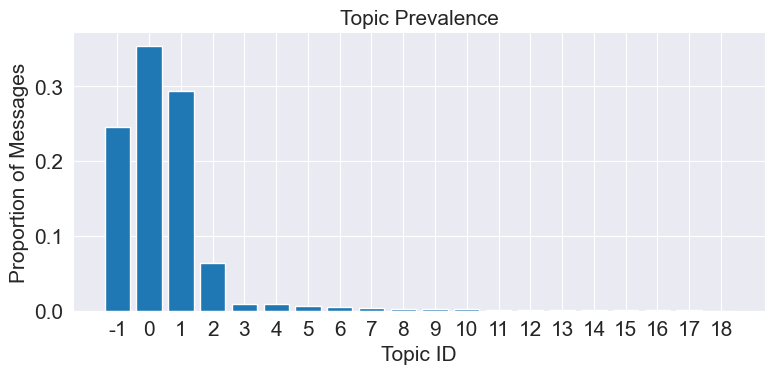

In [40]:
# Topic Prevalence Bar Chart
topic_counts = pd.Series(topics, name='Count').value_counts().sort_index()
df_prevalence = topic_counts.reset_index()
df_prevalence.columns = ['Topic', 'Count']
df_prevalence['Proportion'] = df_prevalence['Count'] / df_prevalence['Count'].sum()

plt.figure(figsize=(8,4))
plt.bar(df_prevalence['Topic'].astype(str), df_prevalence['Proportion'])
plt.xlabel('Topic ID')
plt.ylabel('Proportion of Messages')
plt.title('Topic Prevalence')
plt.tight_layout()
plt.show()

~25 % of messages landed in the “outlier/noise” bucket

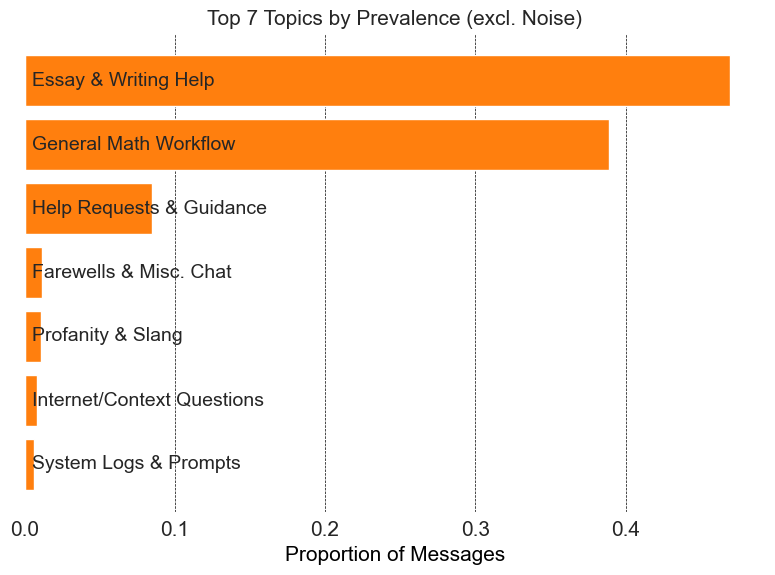

In [70]:
# Build prevalence DataFrame, excluding noise (-1)
topic_counts = pd.Series(topics, name='Count')
df_prevalence = (
    topic_counts[topic_counts != -1]  # drop topic -1
    .value_counts()
    .sort_index()
    .reset_index()
)
df_prevalence.columns = ['Topic', 'Count']
df_prevalence['Proportion'] = df_prevalence['Count'] / df_prevalence['Count'].sum()

# Map human-readable labels
label_map = {
    0:  "Essay & Writing Help",
    1:  "General Math Workflow",
    2:  "Help Requests & Guidance",
    3:  "Farewells & Misc. Chat",
    4:  "Profanity & Slang",
    5:  "Internet/Context Questions",
    6:  "System Logs & Prompts",
    7:  "Engineering/Tech Jargon",
    8:  "Physics & Energy Calculations",
    9:  "Metaphors & Figurative Language",
    10:  "Grammar & Part-of-Speech Queries",
    11:  "DVD-Packing & Combinatorics",
    12:  "Argumentation & Climate Topics",
    13:  "Greetings & Small Talk",
    14:  "Short Requests & Tests",
    15:  "Voice & Measurement Checks",
    16:  "Geography & Cultural References",
    17:  "Energy Consumption Details",
    18:  "“Bright/Dark” Usage Queries"
} # topic labels computed with the help of chatGPT


df_prevalence['Label'] = df_prevalence['Topic'].map(label_map)

# Select top 7 topics by proportion
top_n = 7
df_top = df_prevalence.nlargest(top_n, 'Proportion')


plt.rcParams.update({
    'font.size': 15,
    'font.family': 'sans-serif',
    'axes.titlesize': 15,
    'axes.labelsize': 15
})

# Vizualize
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.barh(
    df_top['Label'],
    df_top['Proportion'],
    color='tab:orange'   )

ax.invert_yaxis()
ax.grid(True, axis='x', color='black', linewidth=0.5, linestyle='--')
ax.set_xlabel('Proportion of Messages',color='black')
ax.set_title(f'Top 7 Topics by Prevalence (excl. Noise)')
ax.set_yticks([])

# Annotate each bar with its topic label
for bar, label in zip(bars, df_top['Label']):
    ax.text(
        0.005,  # small offset on x-axis
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        ha='left',
        fontsize=14
    )
# Transparent background
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
plt.tight_layout()
plt.savefig('RQ2_top_topics_prevalence.png', dpi=300)
plt.show()

### Topic Distribution

After removing all outlier messages (Topic –1), the remaining chat logs concentrate in three main areas:

1. **Essay & Writing Help (Topic 0)**
   - **Count:** 14 435 messages (≈ 47 %)
   - **Interpretation:** Nearly half of all non-noise interactions are students seeking assistance with essay drafting, proofreading, and composition.

2. **General Math Workflow (Topic 1)**
   - **Count:** 11 966 messages (≈ 39 %)
   - **Interpretation:** A large portion of chats involve step-by-step math problem solving, arithmetic calculations, or conceptual explanations.

3. **Help Requests & Guidance (Topic 2)**
   - **Count:** 2 615 messages (≈ 8.5 %)
   - **Interpretation:** These are broad “I don’t understand” or “How do I…?” queries that don’t fit neatly into writing or math categories.

Together, these three topics account for about 94 % of all non-noise messages, reflecting that students primarily use the chatbot for writing and math support.

---

### Remaining Topics (Each < 1 %)

The other 16 clusters each make up under 1 % of messages. They cover areas suc as slang, context questions, technical logs, metaphor/figurative language, grammar checks, climate arguments, and so on. These small clusters capture rare but meaningful topics, ensuring no unique use case is overlooked.

---

**P.S.: Why These Numbers Differ from the Poster Version**
In the poster version, we had enforced `min_topic_size=30`, which forced any cluster with fewer than 30 messages into the outlier bucket (Topic –1). Consequently, some writing‐help and math‐help queries ended up labeled as noise or were forming smaller very similar topics. By lifting that constraint for the final analysis, HDBSCAN could form valid clusters even when they contained only 10–20 documents. As a result:
- **“Essay & Writing Help”** expanded from roughly 25 % (poster) to 47 % (final) because all smaller writing queries now coalesce into one large cluster.
- **“General Math Workflow”** and **“Help Requests & Guidance”** likewise absorbed related sub‐30‐message groups, increasing their shares.
- **Outliers (Topic –1)** shrank from about 31 % to 25 % because fewer messages were forced into noise when small clusters were allowed.

These unrestricted clusters better reflect real‐world chatbot usage, where essay and math assistance genuinely dominate, and only a quarter of interactions are truly miscellaneous or one-off queries.



## UMAP projection of the topics

In [71]:
# UMAP 2D Embedding Scatter
embeddings = topic_model._extract_embeddings(docs_final)
umap_embeddings = topic_model.umap_model.transform(embeddings)

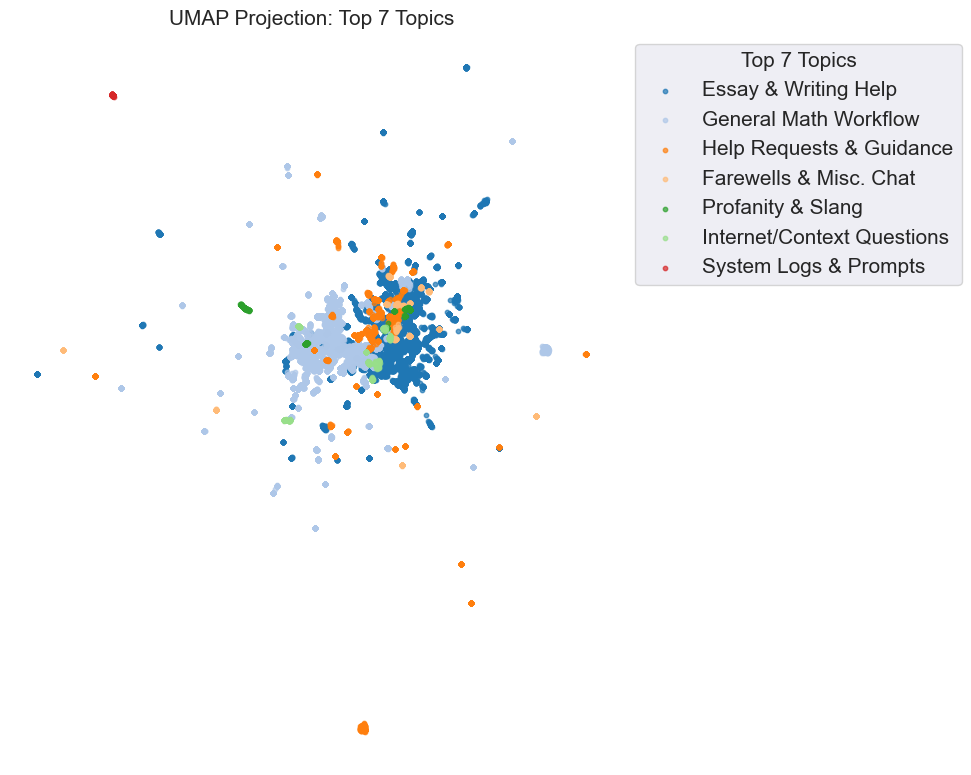

In [73]:
# list of
top_topics = df_prevalence.nlargest(7, 'Proportion')['Topic'].astype(int).tolist()

#  Filter to top topics
mask = np.isin(topics, top_topics)
filtered_embeds = umap_embeddings[mask]
filtered_topics = np.array(topics)[mask]

#  Plot with legend
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')
for i, topic in enumerate(top_topics):
    sel = filtered_topics == topic
    plt.scatter(
        filtered_embeds[sel,0],
        filtered_embeds[sel,1],
        color=cmap(i),
        s=10,
        alpha=0.7,
        label=label_map.get(topic, f"Topic {topic}")
    )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Top 7 Topics')
plt.title("UMAP Projection: Top 7 Topics")
plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# Top Keywords Tables for Top 5 Topics
top5 = df_prevalence.nlargest(3, 'Count')['Topic'].tolist()
for t in top5:
    kw = topic_model.get_topic(t)
    df_kw = pd.DataFrame(kw[:20], columns=['Word','Weight'])
    print(f"\nTop keywords for topic {t}:")
    print(df_kw)


Top keywords for topic 0:
          Word    Weight
0       helfen  0.032584
1       wissen  0.031115
2         beim  0.027908
3     brauchst  0.027202
4    schreiben  0.025725
5         lass  0.024834
6         hast  0.023502
7   gymiprfung  0.023040
8       kannst  0.023011
9         mehr  0.021851
10       hilfe  0.021078
11     aufgabe  0.021020
12       hallo  0.020896
13       gerne  0.020499
14      fragen  0.019911
15     mchtest  0.019855
16     aufsatz  0.019604
17        klar  0.016667
18       helfe  0.016137
19         tue  0.014640

Top keywords for topic 1:
         Word    Weight
0         num  0.054064
1       frack  0.026690
2        text  0.021754
3     schritt  0.017745
4       limes  0.016187
5   berechnen  0.015318
6      anzahl  0.014875
7        lass  0.014602
8   gleichung  0.014491
9        hast  0.014053
10    minuten  0.013121
11      viele  0.012331
12       zahl  0.011428
13       zeit  0.011205
14     wissen  0.011187
15    stunden  0.010937
16         kg

## Top words for the topics

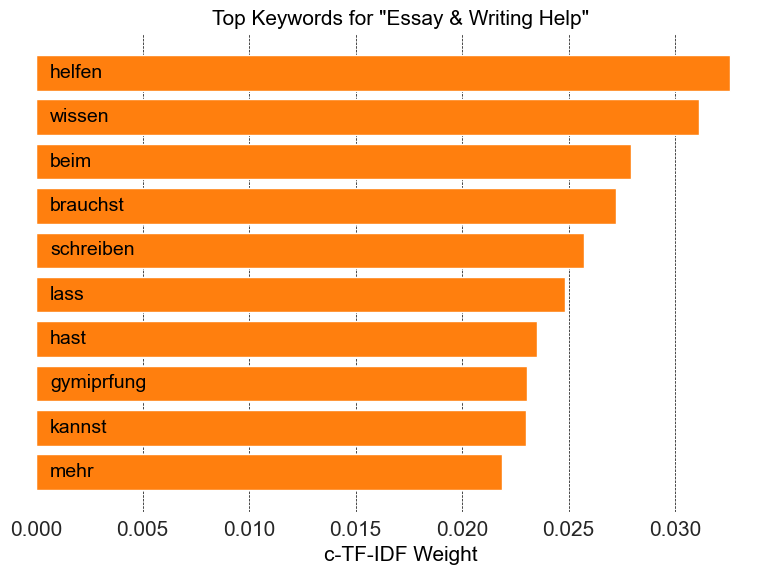

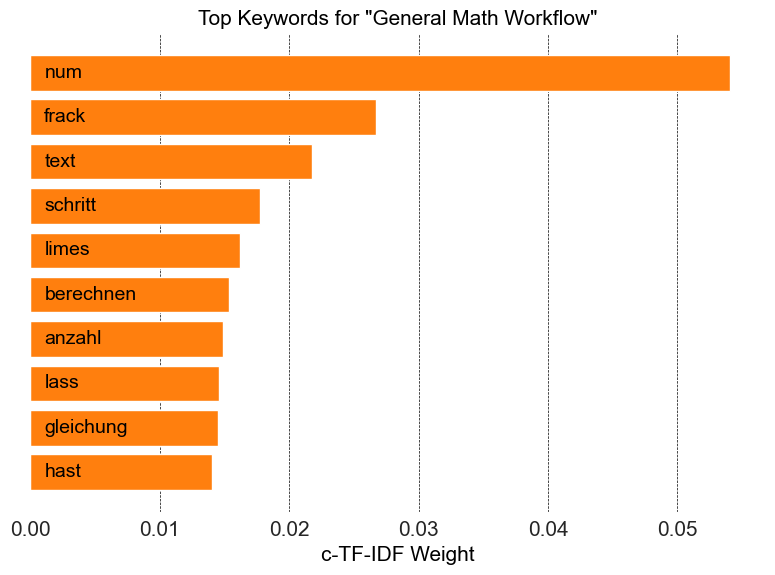

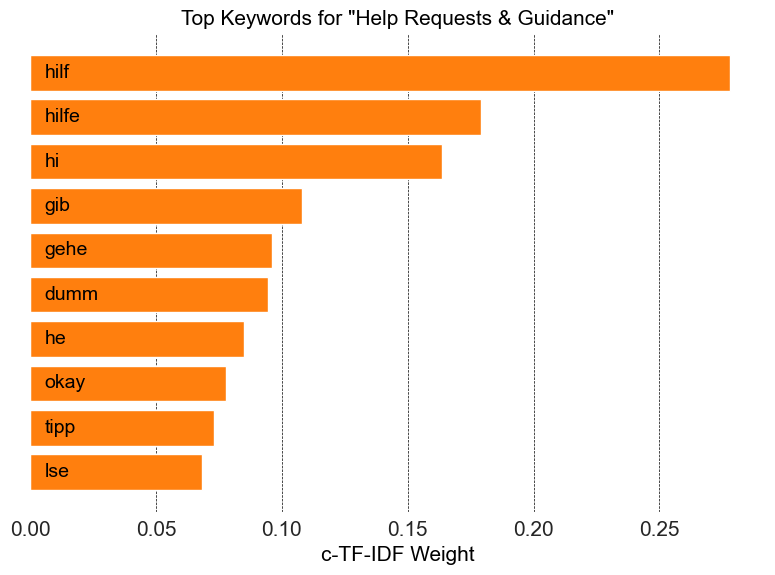

In [69]:
top3 = df_prevalence.nlargest(3, "Count")["Topic"].tolist()

for t in top3:
    #  human‐readable label
    topic_label = label_map.get(t, f"Topic {t}")

    # Retrieve up to 20 keywords for topic t
    kw = topic_model.get_topic(t)
    kw_filtered = [(w, wt) for w, wt in kw if isinstance(w, str) and w]
    df_kw = pd.DataFrame(kw_filtered[:10], columns=["Word", "Weight"])

    # styling
    plt.rcParams.update({
        "font.size": 15,
        "font.family": "sans-serif",
        "axes.titlesize": 15,
        "axes.labelsize": 15
    })

    # new figure + axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # draw horizontal bars
    bars = ax.barh(
        df_kw["Word"],
        df_kw["Weight"],
        color="tab:orange"
    )

    # invert y so largest is on top
    ax.invert_yaxis()

    # dashed grid on x‐axis
    ax.grid(True, axis="x", color="black", linewidth=0.5, linestyle="--")

    # labels + title
    ax.set_xlabel("c-TF-IDF Weight", color="black")
    ax.set_title(f'Top Keywords for "{topic_label}"', color="black")

    # remove default y‐ticks
    ax.set_yticks([])

    # compute a single x‐offset = 2% of this topic’s max weight
    x_offset = df_kw["Weight"].max() * 0.02

    # annotate every bar at exactly x = x_offset (same for all)
    for bar, word in zip(bars, df_kw["Word"]):
        ax.text(
            x_offset,
            bar.get_y() + bar.get_height() / 2,
            word,
            va="center",
            ha="left",
            fontsize=14,
            color="black"
        )

    # transparent backgrounds
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)

    # save to PNG
    safe_label = topic_label.replace(" ", "_").replace("&", "and")
    plt.tight_layout()
    plt.savefig(f"RQ2_top_keywords_{safe_label}.png", dpi=300)
    plt.show()